In [1]:
import pandas as pd 
import numpy as np 
import pingouin as pg 
import seaborn as sns
import matplotlib.pyplot as plt

### A - Group comparisons 
1. Compare diffusion metrics between control and preterm group (subdivided by 32 weeks to extreme and moderate preterm): paired t-test with multiple comparison correction​

2. Linear regression of preterm metrics with age at birth ​

3. Linear regression of preterm metrics with age at birth adjusted for clinical variables of interest

In [2]:
# read in the metric files saved as csv
controls = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_control_group_mergedLR.csv', index_col=0)
preterms = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_preterm_group_mergedLR.csv', index_col=0)

#remove subthalamus
cols_to_keep = [col for col in controls.columns if 'Subthal' not in col]
controls = controls[cols_to_keep]
preterms = preterms[cols_to_keep]


### first get all regions pairs, metrics to be evaluated 
tract_names = np.unique(np.array([tract.split('_')[0] for tract in controls.columns[2:]]))
print('Number of evaluated bundles: {}'.format(len(tract_names)))
metrics = np.unique(np.array([tract.partition('_')[-1] for tract in controls.columns[2:]]))

### create pairing - as there is fewer preterms, use their IDs to find matches with controls 
matched = pd.read_csv('../../DerivedData/subject_matching.csv', index_col=0)
matched = matched[matched['preterm_ID'].isin(preterms['subject_id'].values)]

#sanity check: 
if len(preterms) == len(matched):
    print('Number of subject pairs: {}'.format(len(preterms)))
else:
    print('Someting happened with matching')
    
# get age at birth info for the subgrouping
ages = pd.read_csv('../../SourceData/release3_subject_info.tsv', sep='\t')

matched['preterm_birth_age'] = 0.
matched['control_birth_age'] = 0.
for i, row in matched.iterrows():
    matched.at[i, 'preterm_birth_age']  = ages[ages['participant_id '] == row['preterm_ID']+' ']['birth_age '].values[0]
    matched.at[i, 'control_birth_age']  = ages[ages['participant_id '] == row['matched_ID_with_outcome']+' ']['birth_age '].values[0]
    
### creates subgrouped pairs:
extreme_pairs = matched[matched.preterm_birth_age < 32][['preterm_ID','matched_ID_with_outcome']]
moderate_pairs = matched[matched.preterm_birth_age >= 32][['preterm_ID','matched_ID_with_outcome']]

extreme_pairs.rename(columns={'matched_ID_with_outcome': 'matched_ID'}, inplace=True)
moderate_pairs.rename(columns={'matched_ID_with_outcome': 'matched_ID'}, inplace=True)

# sanity check 
if (len(extreme_pairs) + len(moderate_pairs)) == len(matched):
    print('Extreme group: N = {}\nModerate group: N = {}'.format(len(extreme_pairs), len(moderate_pairs)))
else:
    print('Grouping wrong')
    
    

Number of evaluated bundles: 18
Number of subject pairs: 59
Extreme group: N = 33
Moderate group: N = 26


In [3]:
df = pd.DataFrame(columns=['tract', 'metric', 'uncorrected_p', 'corrected_p_bonf', 'corrected_p_fdr_bh', 'corrected_p_holm'])
i = 0
for tract in tract_names:
    #print(tract)
    for metric in metrics:
        #print(metric)
        col_name = tract+'_'+metric
        
        #df = pd.DataFrame(columns=['ID', 'preterm', 'term'])
        #df['ID'] = extreme_pairs['preterm_ID'].values
        #df['preterm'] = np.array([ preterms[preterms['subject_id'] == subj_id][col_name].values[0] for subj_id  in extreme_pairs['preterm_ID'].values])
        #df['term'] = [ controls[controls['subject_id'] == subj_id][col_name].values[0] for subj_id  in extreme_pairs['matched_ID'].values]
                
        prt_array = [ preterms[preterms['subject_id'] == subj_id][col_name].values[0] for subj_id  in extreme_pairs['preterm_ID'].values]
        ctrl_array = [ controls[controls['subject_id'] == subj_id][col_name].values[0] for subj_id  in extreme_pairs['matched_ID'].values]
        
        test = pg.ttest(x = prt_array, y=ctrl_array, paired=True)
        #reject, pvals_corr = pg.multicomp(pvals, method='fdr_bh')
        
        
        p = "{:.7f}".format(test['p-val'].values[0])
        #print(p)
        
        df.loc[i, 'tract'] = tract
        df.loc[i, 'metric'] = metric
        df.loc[i, 'uncorrected_p'] = p
        i = i+1
        
        
df['uncorrected_p'] = df['uncorrected_p'].astype(np.float64)

df.uncorrected_p = np.round(df.uncorrected_p,6)
reject, pvals_corr = pg.multicomp(df['uncorrected_p'].values, method='fdr_bh')
df['corrected_p_fdr_bh'] = pvals_corr

reject, pvals_corr = pg.multicomp(df['uncorrected_p'].values, method='bonf')
df['corrected_p_bonf'] = pvals_corr

reject, pvals_corr = pg.multicomp(df['uncorrected_p'].values, method='holm')
df['corrected_p_holm'] = pvals_corr




In [4]:
df.to_csv('../../Results/extreme_preterm_vs_control_paired_ttest_per_bundle_per_metric_mergedLR.csv')

In [5]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color='darkgray')
    plt.setp(bp['caps'], color='darkgray')
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['fliers'], color='darkgray', alpha=0.5)
    
def get_notation(tract_names,metric, correction):
    notation = []
    for tract in tract_names:
        if df.loc[(df['tract'] == tract) & (df['metric'] == metric)][correction].values[0] < 0.001:
            notation.append('***')
        elif 0.001 <= df.loc[(df['tract'] == tract) & (df['metric'] == metric)][correction].values[0] < 0.01:
            notation.append('**')
        elif 0.01 <= df.loc[(df['tract'] == tract) & (df['metric'] == metric)][correction].values[0] < 0.05:
            notation.append('*')
        else:
            notation.append(' ')
    return np.array(notation) 

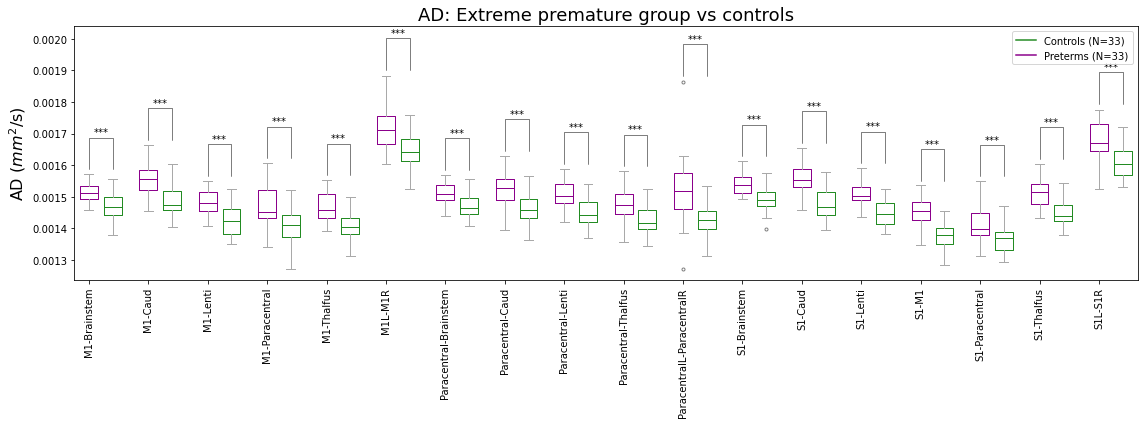

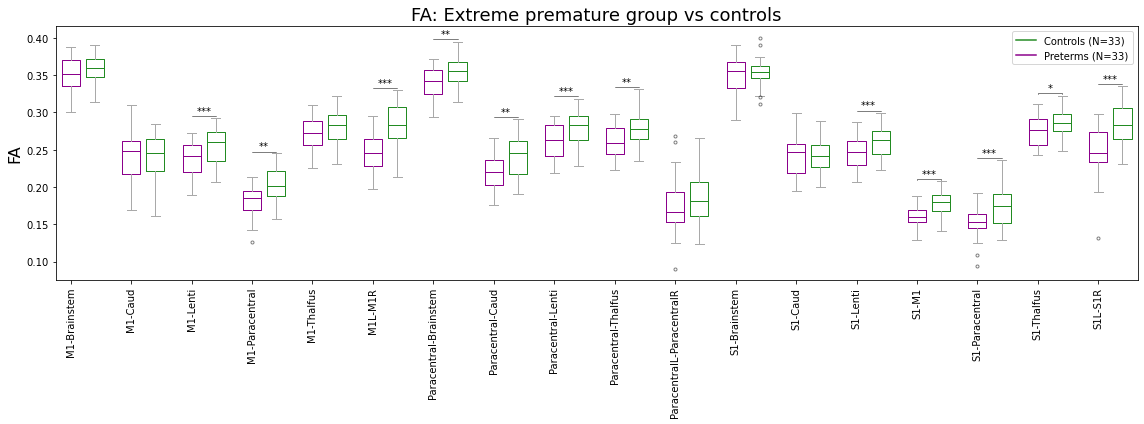

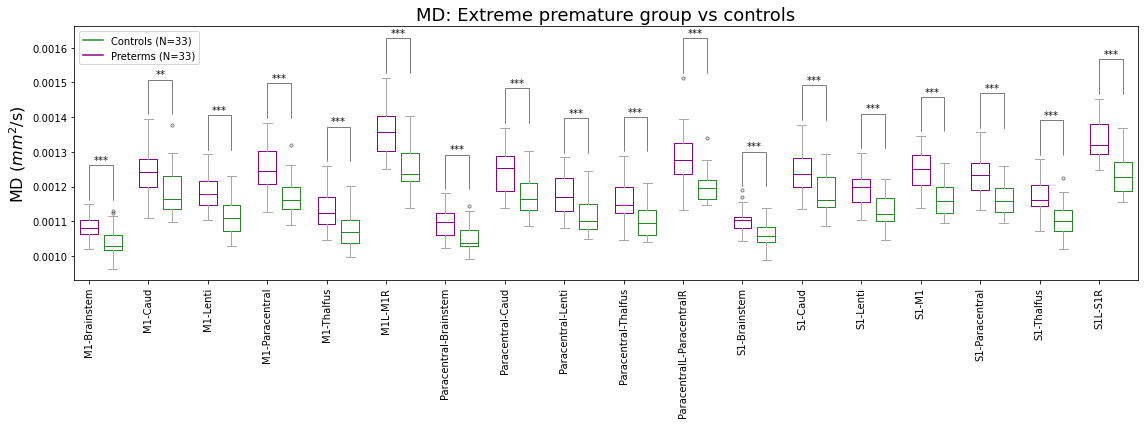

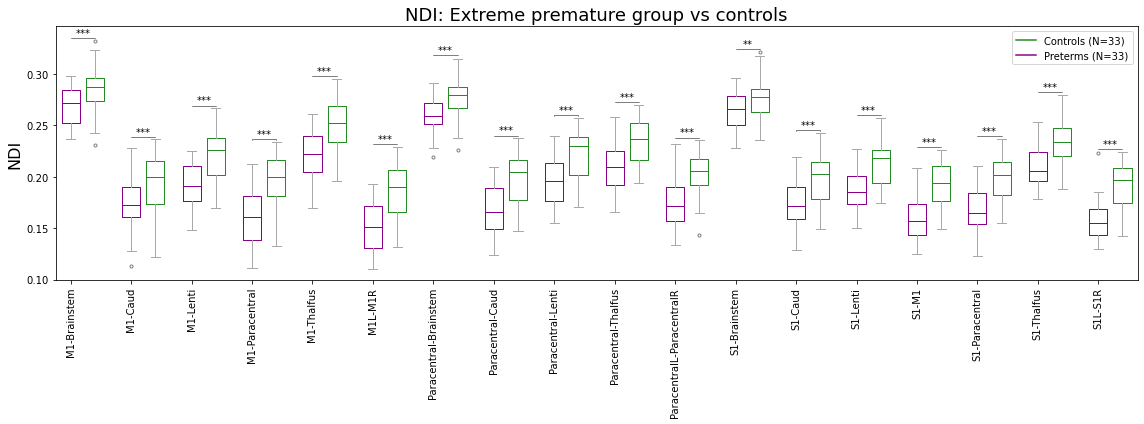

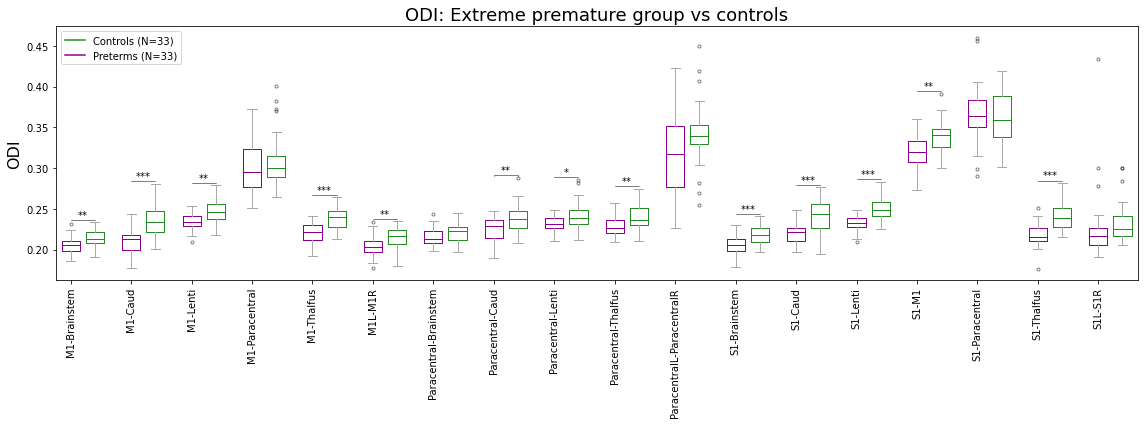

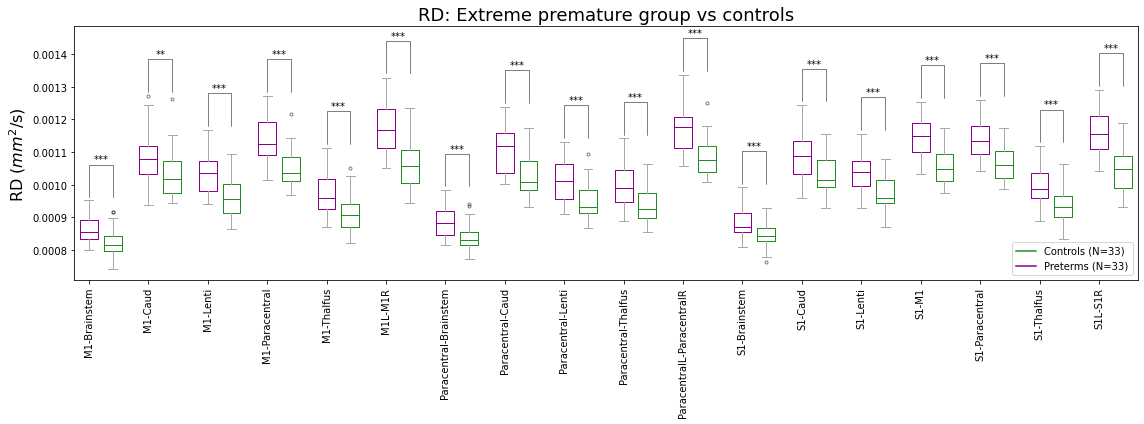

In [6]:

for metric in metrics:

  #if 'pre' not in metric:
    names_labels = [ tract+'_'+metric for tract in tract_names]

    control_sub = controls[controls['subject_id'].isin(extreme_pairs['matched_ID'].values)][names_labels]
    preterm_sub = preterms[preterms['subject_id'].isin(extreme_pairs['preterm_ID'].values)][names_labels]

    plt.figure(figsize=(16,6))

    bpl = plt.boxplot(preterm_sub.values, positions=np.array(range(len(names_labels)))*2.0-0.4, sym='.', 
            widths=0.6, vert=True, labels=tract_names, showfliers=True)
    bpr = plt.boxplot(control_sub.values, positions=np.array(range(len(names_labels)))*2.0+0.4, sym='.', 
                  widths=0.6, vert=True, labels=tract_names, showfliers=True)


    set_box_color(bpl, 'darkmagenta') # colors are from http://colorbrewer2.org
    set_box_color(bpr, 'forestgreen')
    
    ## plot significe 
    notation = get_notation(tract_names=tract_names, metric=metric, correction='corrected_p_fdr_bh')
    
    for i, txt in enumerate(notation):
        if txt != ' ':
            x1,x2 = (np.array(range(len(names_labels)))*2.0-0.4)[i], (np.array(range(len(names_labels)))*2.0+0.4)[i]
            
            if control_sub[names_labels[i]].max() > preterm_sub[names_labels[i]].max():
                y, h, col = control_sub[names_labels[i]].max() * 1.01 , 0.0001, 'k'
            else: 
                y, h, col = preterm_sub[names_labels[i]].max() * 1.01, 0.0001, 'k'
                
            plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
            plt.text((x1+x2)*.5, y+h, txt, ha='center', va='bottom', color=col)
                
                
    ticks = np.array(range(len(names_labels)))*2.0-0.4
    plt.xticks(ticks, rotation=90, labels=tract_names)
    # draw temporary red and blue lines and use them to create a legend\n",
    plt.plot([], c='forestgreen', label='Controls (N={})'.format(len(control_sub)))
    plt.plot([], c='darkmagenta', label='Preterms (N={})'.format(len(preterm_sub)))
    plt.legend()
    plt.title('{}: Extreme premature group vs controls'.format(metric), fontsize=18)
    
    if metric in ['AD', 'RD', 'MD']:
        
        plt.ylabel('{} ({})'.format(metric, '$mm^2$/s' ), fontsize=16)
    else: 
        plt.ylabel('{}'.format(metric ), fontsize=16)
    plt.tight_layout()
    plt.savefig('../../Results/figures/ExtremeVSControl_{}_distribution_ttest_mergedLR.png'.format(metric), dpi=300 )
    plt.show()

## moderate preterms


In [7]:
df = pd.DataFrame(columns=['tract', 'metric', 'uncorrected_p', 'corrected_p_bonf', 'corrected_p_fdr_bh', 'corrected_p_holm'])
i = 0
for tract in tract_names:
    #print(tract)
    for metric in metrics:
        #print(metric)
        col_name = tract+'_'+metric
        
        #df = pd.DataFrame(columns=['ID', 'preterm', 'term'])
        #df['ID'] = extreme_pairs['preterm_ID'].values
        #df['preterm'] = np.array([ preterms[preterms['subject_id'] == subj_id][col_name].values[0] for subj_id  in extreme_pairs['preterm_ID'].values])
        #df['term'] = [ controls[controls['subject_id'] == subj_id][col_name].values[0] for subj_id  in extreme_pairs['matched_ID'].values]
                
        prt_array = [ preterms[preterms['subject_id'] == subj_id][col_name].values[0] for subj_id  in moderate_pairs['preterm_ID'].values]
        ctrl_array = [ controls[controls['subject_id'] == subj_id][col_name].values[0] for subj_id  in moderate_pairs['matched_ID'].values]
        
        test = pg.ttest(x = prt_array, y=ctrl_array, paired=True)
        #reject, pvals_corr = pg.multicomp(pvals, method='fdr_bh')
        
        
        p = "{:.7f}".format(test['p-val'].values[0])
        #print(p)
        
        df.loc[i, 'tract'] = tract
        df.loc[i, 'metric'] = metric
        df.loc[i, 'uncorrected_p'] = p
        i = i+1
        
        
df['uncorrected_p'] = df['uncorrected_p'].astype(np.float64)

df.uncorrected_p = np.round(df.uncorrected_p,6)
reject, pvals_corr = pg.multicomp(df['uncorrected_p'].values, method='fdr_bh')
df['corrected_p_fdr_bh'] = pvals_corr

reject, pvals_corr = pg.multicomp(df['uncorrected_p'].values, method='bonf')
df['corrected_p_bonf'] = pvals_corr

reject, pvals_corr = pg.multicomp(df['uncorrected_p'].values, method='holm')
df['corrected_p_holm'] = pvals_corr


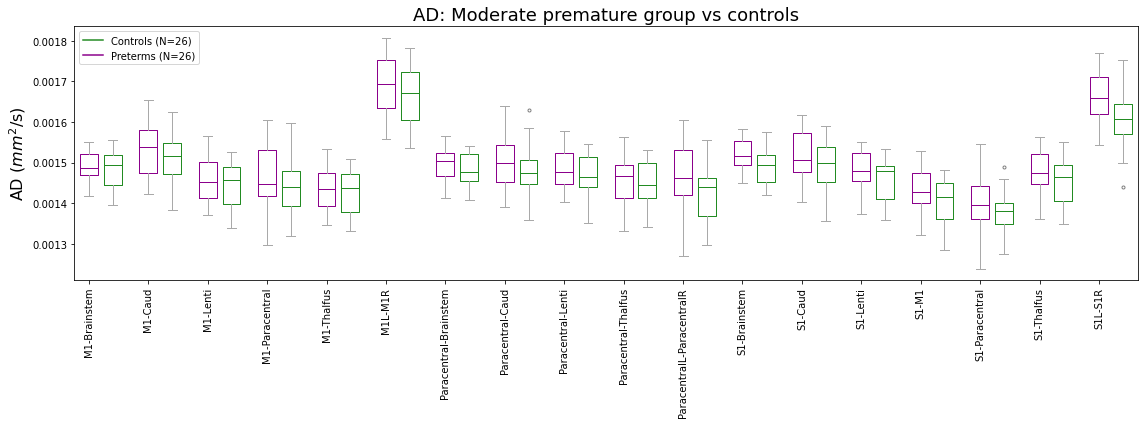

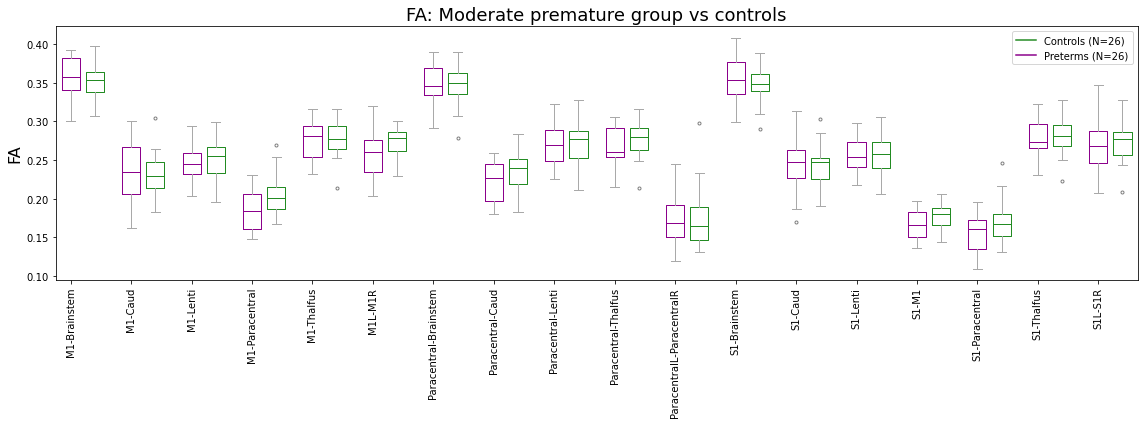

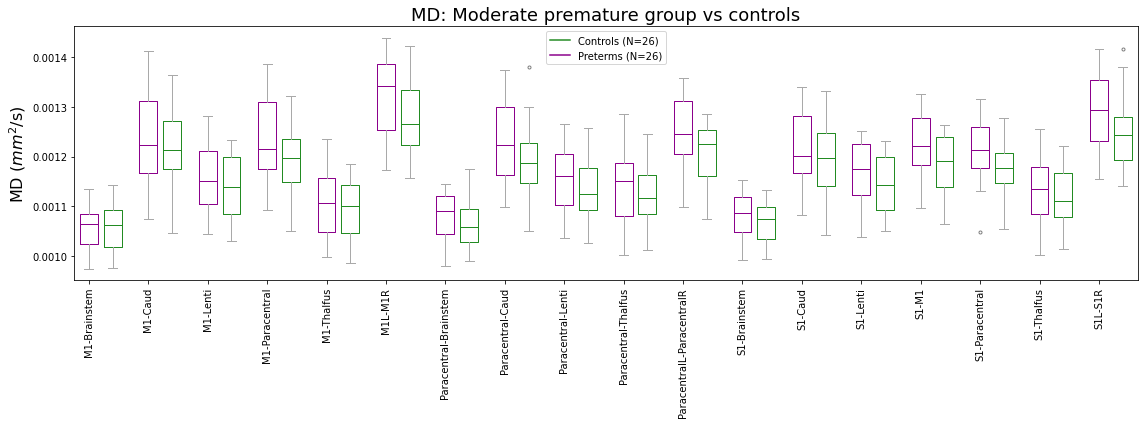

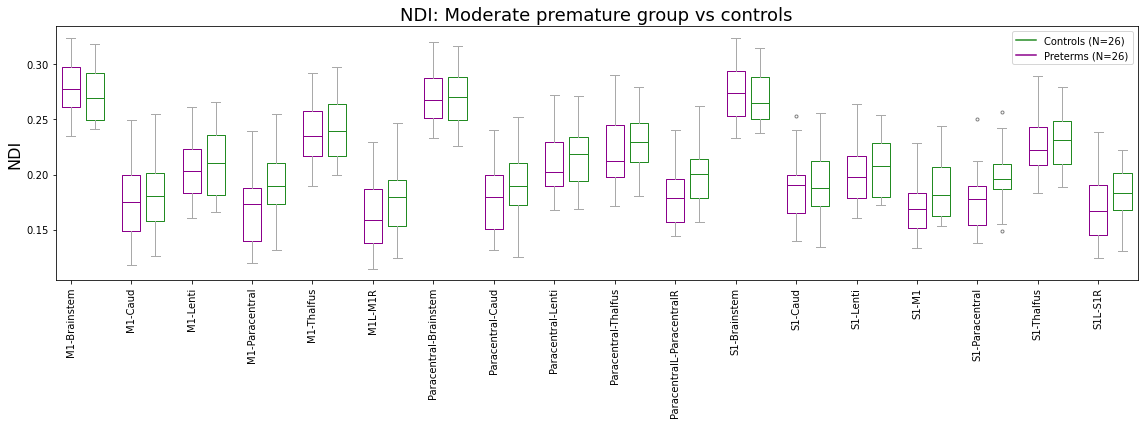

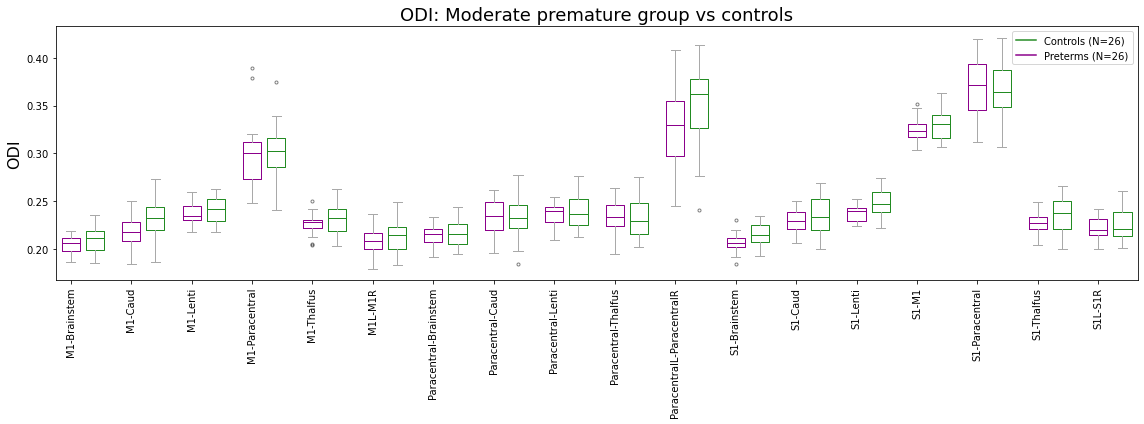

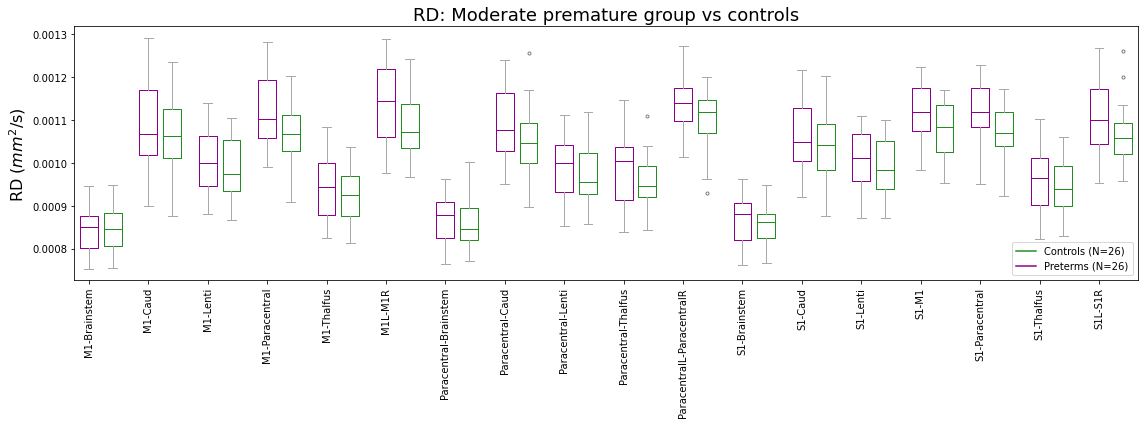

In [8]:
for metric in metrics:

  #if 'pre' not in metric:
    names_labels = [ tract+'_'+metric for tract in tract_names]

    control_sub = controls[controls['subject_id'].isin(moderate_pairs['matched_ID'].values)][names_labels]
    preterm_sub = preterms[preterms['subject_id'].isin(moderate_pairs['preterm_ID'].values)][names_labels]

    plt.figure(figsize=(16,6))

    bpl = plt.boxplot(preterm_sub.values, positions=np.array(range(len(names_labels)))*2.0-0.4, sym='.', 
            widths=0.6, vert=True, labels=tract_names, showfliers=True)
    bpr = plt.boxplot(control_sub.values, positions=np.array(range(len(names_labels)))*2.0+0.4, sym='.', 
                  widths=0.6, vert=True, labels=tract_names, showfliers=True)


    set_box_color(bpl, 'darkmagenta') # colors are from http://colorbrewer2.org
    set_box_color(bpr, 'forestgreen')
    
    ## plot significe 
    notation = get_notation(tract_names=tract_names, metric=metric, correction='corrected_p_fdr_bh')
    
    for i, txt in enumerate(notation):
        if txt != ' ':
            x1,x2 = (np.array(range(len(names_labels)))*2.0-0.4)[i], (np.array(range(len(names_labels)))*2.0+0.4)[i]
            
            if control_sub[names_labels[i]].max() > preterm_sub[names_labels[i]].max():
                y, h, col = control_sub[names_labels[i]].max() * 1.01 , 0.0001, 'k'
            else: 
                y, h, col = preterm_sub[names_labels[i]].max() * 1.01, 0.0001, 'k'
                
            plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
            plt.text((x1+x2)*.5, y+h, txt, ha='center', va='bottom', color=col)
                
                
    ticks = np.array(range(len(names_labels)))*2.0-0.4
    plt.xticks(ticks, rotation=90, labels=tract_names)
    # draw temporary red and blue lines and use them to create a legend\n",
    plt.plot([], c='forestgreen', label='Controls (N={})'.format(len(control_sub)))
    plt.plot([], c='darkmagenta', label='Preterms (N={})'.format(len(preterm_sub)))
    plt.legend()
    plt.title('{}: Moderate premature group vs controls'.format(metric), fontsize=18)

    if metric in ['AD', 'RD', 'MD']:
        
        plt.ylabel('{} ({})'.format(metric, '$mm^2$/s' ), fontsize=16)
    else: 
        plt.ylabel('{}'.format(metric ), fontsize=16)
        
    plt.tight_layout()
    plt.savefig('../../Results/figures/ModerateVSControl_{}_distribution_ttest_mergedLR.png'.format(metric), dpi=300 )
    plt.show()

# Evaluating to change of MRI parameters with age 
1. Linear regression over all 59*2 babies
2. Adjust for the Sara's clinical variables 

In [9]:
preterms_for_corr = preterms.copy()
controls_for_corr = controls[controls.subject_id.isin(matched.matched_ID_with_outcome.values)].copy()
#controls_for_corr.reset_index(inplace=True)

preterms_for_corr['birth_age'] = 0.0
for i, row in preterms_for_corr.iterrows():
    preterms_for_corr.loc[i,'birth_age'] =matched[matched.preterm_ID == row.subject_id].preterm_birth_age.values[0]
    
controls_for_corr['birth_age'] = 0.0
for i, row in controls_for_corr.iterrows():
    controls_for_corr.loc[i,'birth_age'] =matched[matched.matched_ID_with_outcome == row.subject_id].control_birth_age.values[0]
        
        
df_regression = pd.concat([preterms_for_corr, controls_for_corr])

In [10]:
df = pd.DataFrame(columns=['tract', 'metric', 'uncorrected_p', 'corrected_p_bonf', 'corrected_p_fdr_bh', 'corrected_p_holm'])
i = 0
for tract in tract_names:
    #print(tract)
    for metric in metrics:
        #print(metric)
        col_name = tract+'_'+metric
        
        #df = pd.DataFrame(columns=['ID', 'preterm', 'term'])
        #df['ID'] = extreme_pairs['preterm_ID'].values
        #df['preterm'] = np.array([ preterms[preterms['subject_id'] == subj_id][col_name].values[0] for subj_id  in extreme_pairs['preterm_ID'].values])
        #df['term'] = [ controls[controls['subject_id'] == subj_id][col_name].values[0] for subj_id  in extreme_pairs['matched_ID'].values]
                
        #prt_array = [ for_corr[for_corr['subject_id'] == subj_id][col_name].values[0] for subj_id  in extreme_pairs['preterm_ID'].values]
        #age = [ for_corr[for_corr['subject_id'] == subj_id]['birth_age'].values[0] for subj_id  in extreme_pairs['preterm_ID'].values]
        #ctrl_array = [ controls[controls['subject_id'] == subj_id][col_name].values[0] for subj_id  in extreme_pairs['matched_ID'].values]
        
        #test = pg.ttest(x = prt_array, y=ctrl_array, paired=True)
        test = pg.linear_regression(df_regression[col_name], df_regression['birth_age'])
        #reject, pvals_corr = pg.multicomp(pvals, method='fdr_bh')
        
        
        p = "{:.7f}".format(test['pval'].values[0])
        #print(p)
        
        df.loc[i, 'tract'] = tract
        df.loc[i, 'metric'] = metric
        df.loc[i, 'uncorrected_p'] = p
        i = i+1        
        
df['uncorrected_p'] = df['uncorrected_p'].astype(np.float64)

df.uncorrected_p = np.round(df.uncorrected_p,6)
reject, pvals_corr = pg.multicomp(df['uncorrected_p'].values, method='fdr_bh')
df['corrected_p_fdr_bh'] = pvals_corr

reject, pvals_corr = pg.multicomp(df['uncorrected_p'].values, method='bonf')
df['corrected_p_bonf'] = pvals_corr

reject, pvals_corr = pg.multicomp(df['uncorrected_p'].values, method='holm')
df['corrected_p_holm'] = pvals_corr

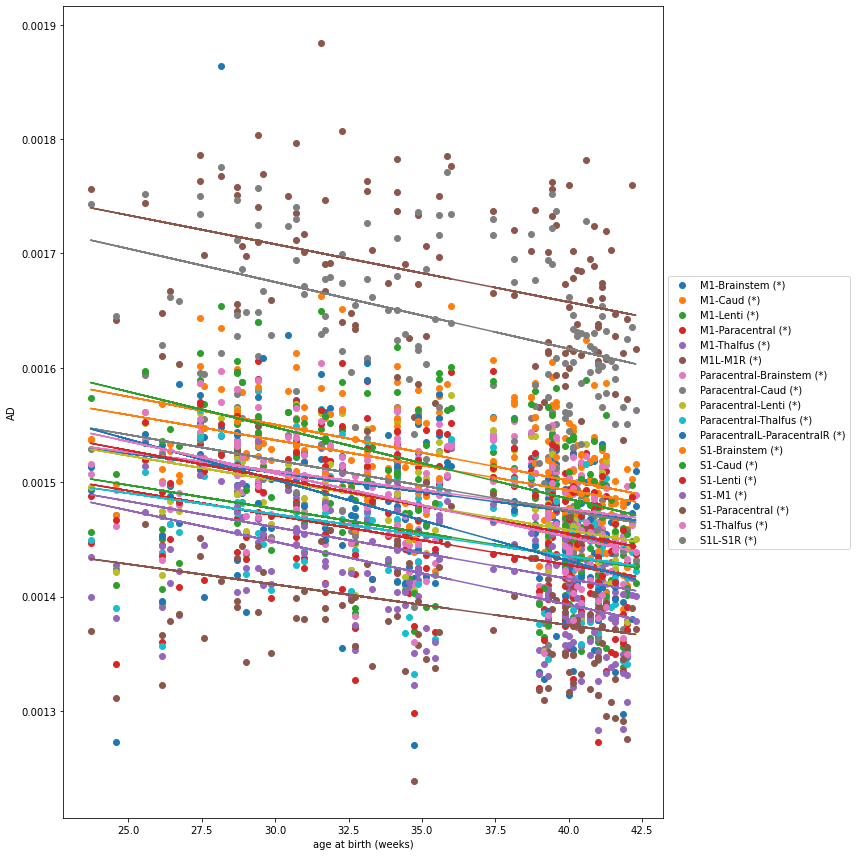

In [11]:
metric = 'AD'
fig, axs = plt.subplots(1,1, figsize=(12, 12))
for tract in tract_names:
    
   
    if df[(df.tract == tract) & (df.metric == 'FA')].corrected_p_fdr_bh.values[0] > 0.05:
        label = '(n.s)'
    else: 
        label= '(*)'

    axs.scatter( df_regression['birth_age'], df_regression[tract+'_'+metric].values, label=tract+' '+label)
    
    if label != '(n.s)':
        m, b = np.polyfit(df_regression['birth_age'], df_regression[tract+'_'+metric].values, 1)
        axs.plot(df_regression['birth_age'], m*df_regression['birth_age'] + b)

axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.title('Centered', fontsize=16)
plt.xlabel('age at birth (weeks)')
plt.ylabel('{}'.format(metric))
plt.tight_layout()
fig.savefig('../../Results/figures/example_univariate_ADvsBirthAge.png', dpi=300)
plt.show()

In [66]:
len(df)

312